In [3]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
from sklearn.gaussian_process import kernels, GaussianProcessRegressor
import pandas as pd
import time
if os.getcwd() == '/Users/cd8607/Documents/Fitting_Potential':
    pass
else:
    os.chdir('../')


txt = ['txt.alloy', 'eam.txt', 'loss.txt']

[file for file in txt if file.endswith('.alloy')]

['txt.alloy']

In [3]:
whe = np.loadtxt('Potentials/W-He-Juslin.table',skiprows=6)[:,1:3]

In [4]:
def ZBL(rij, Zi, Zj):
    
    e0 = 55.26349406e-4

    const = 1/(4*np.pi*e0)

    a = 0.46850/(Zi**0.23 + Zj**0.23)	

    x = rij/a

    x = x[:, np.newaxis]

    amplitude = np.array([0.18175, 0.50986, 0.28022, 0.02817])
    exponent = np.array([3.19980, 0.94229, 0.40290, 0.20162])

    phi = np.sum(amplitude * np.exp(-exponent * x), axis=1)
         
    return const*phi*(Zi*Zj/rij)

def ZBL_approx(rij, Zi, Zj):
    
    e0 = 55.26349406e-4

    const = 1/(4*np.pi*e0)

    a = 0.46850/(Zi**0.23 + Zj**0.23)	

    x = rij/a

    amplitude = np.array([0.18175, 0.50986, 0.28022, 0.02817])
    exponent = np.array([3.19980, 0.94229, 0.40290, 0.20162])


    phi = np.sum(amplitude) - np.sum(amplitude*exponent)*x
    
    print(np.sum(amplitude*exponent))
    
    return const*phi*(Zi*Zj/rij)

In [5]:
class BayesOpt_PairPot():
        
    def __init__(self, n_params, Zi, Zj):

        self.n_params = n_params

        self.Zi = Zi
        self.Zj = Zj

        self.sample_params()

        self.zbl_amplitude = np.array([0.18175, 0.50986, 0.28022, 0.02817])
        self.zbl_exponent =  np.array([3.19980, 0.94229, 0.40290, 0.20162])
    
    def sample_params(self):

        self.amplitude = np.random.normal(loc = 0, scale = 4, size = (self.n_params,))
        self.mean  = np.linspace(0,1,self.n_params)
        self.sigma = 0.3*np.ones((self.n_params,))

        self.params = np.hstack([self.amplitude, self.mean, self.sigma])

    def set_params(self, params):

        self.amplitude = params[:self.n_params]
        self.mean = params[self.n_params:2*self.n_params]
        self.sigma = params[2*self.n_params:]


    def eval(self, rij):
            
        e0 = 55.26349406e-4

        const = 1/(4*np.pi*e0)

        a = 0.46850/(self.Zi**0.23 + self.Zj**0.23)	
        
        x = rij/a

        x = x[:,np.newaxis]

        phi = np.sum( self.zbl_amplitude* np.exp(-self.zbl_exponent * x), axis=1 )

        return const*phi*(self.Zi*self.Zj/rij) + np.sum( (self.amplitude/(rij[:,np.newaxis]*self.sigma*np.sqrt(2*np.pi)))*np.exp(-(np.log(rij[:,np.newaxis])-self.mean)**2/(2*self.sigma**2)) , axis=1 )


    def loss(self, x, y):

        fx = self.eval(x)

        return np.sum( ((y-fx)**2) )/len(x)
    
    def get_nsamples(self, n, rij, y):

        sampled_loss = np.zeros((n,))
        sampled_params = np.zeros((n, len(self.params)))

        for i in range(n):
            
            self.sample_params()
            sampled_loss[i]   = self.loss(rij, y)
            sampled_params[i] = self.params

        return sampled_loss, sampled_params

In [6]:
Zi = 74
Zj = 2

rand = np.random.randint(low = 0, high = len(whe), size=(5,))

rij = whe[rand,0]

# zbl = ZBL(rij, Zi, Zj)
zbl = whe[rand,1]

opt = BayesOpt_PairPot(4, Zi, Zj)

sampled_loss, sampled_params = opt.get_nsamples(1000, rij, zbl)


0.09932452086063477
(array([-0.55118675,  1.05848948, -0.18968208, -0.7579924 ]), array([0.        , 0.33333333, 0.66666667, 1.        ]), array([0.3, 0.3, 0.3, 0.3]))


/var/folders/s9/zg8t26bx2xg094_h3_f559v40000gp/T/ipykernel_9049/689390228.py:15: RuntimeWarning: divide by zero encountered in log
  plt.scatter(np.log(whe[:,0]), np.log(whe[:,1]))


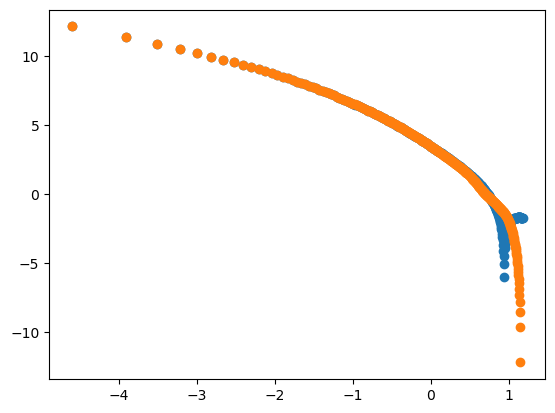

In [7]:
print(sampled_loss.min())

min_params = sampled_params[sampled_loss.argmin()]

opt.set_params(min_params)

# rij = np.logspace(1,-7,100)

# zbl = ZBL(rij, 1, 2)


plty = opt.eval(whe[:,0])

plt.scatter(np.log(whe[:,0]), np.log(np.abs(plty)))
plt.scatter(np.log(whe[:,0]), np.log(whe[:,1]))

print((opt.amplitude, opt.mean, opt.sigma))

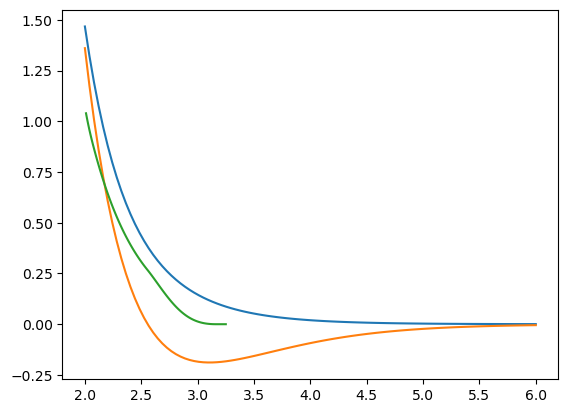

In [8]:
rij = np.linspace(2, 6, 100)

plt.plot(rij, ZBL(rij, 74, 2))
plt.plot(rij, opt.eval(rij))
plt.plot(whe[200:,0], whe[200:,1] )

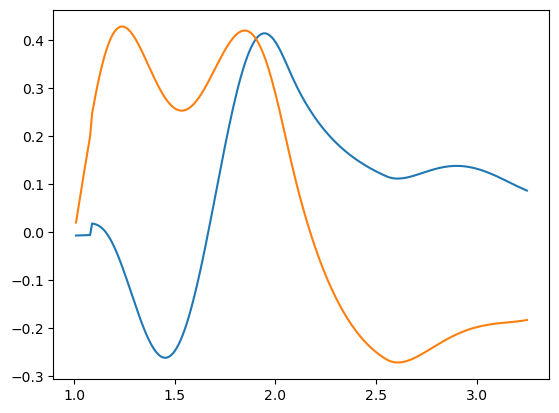

In [9]:
# plt.plot(whe[100:,0], whe[100:,1])
plt.plot(whe[100:,0], ZBL(whe[100:,0], 74, 2) - whe[100:,1] )
plt.plot(whe[100:,0], opt.eval(whe[100:,0]) - whe[100:,1] )

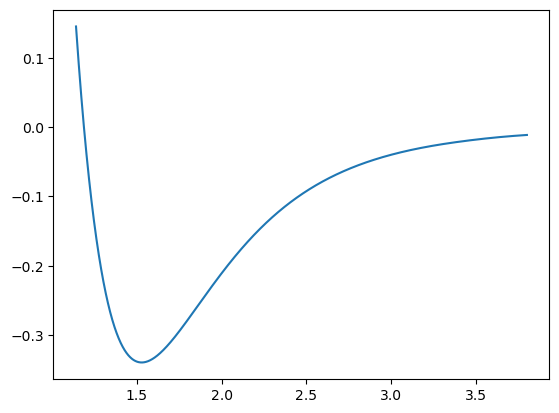

In [10]:
data = np.loadtxt('Potentials/He-Beck1968_modified.table', skiprows = 7)[:, [1,2]]

k = 1500

plt.plot(data[k:,0], data[k:, 1] - ZBL(data[k:,0], 2, 2))

[0 0 1 0 0 1 0 0 1 0]


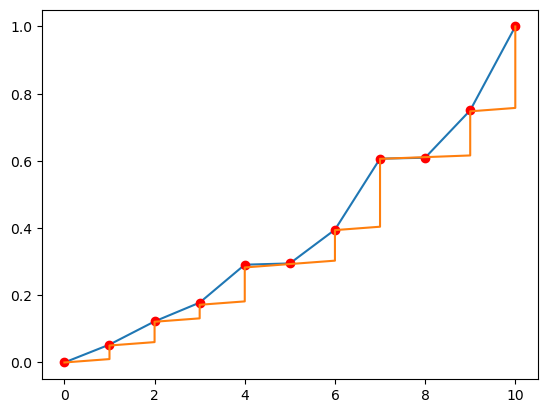

In [11]:
fitness = np.random.rand(10)**2

prob = fitness/np.sum(fitness)

cprob = np.hstack([0,np.cumsum(prob)])

plt.plot(cprob)
plt.plot(cprob,'ro')

index = np.zeros((100,))
x_arr = np.linspace(0,1,100)

for i, x in enumerate(x_arr):
    index[i] = np.searchsorted(cprob, x)

plt.plot(index, x_arr)

print(np.random.randint(0,2,(10,)))


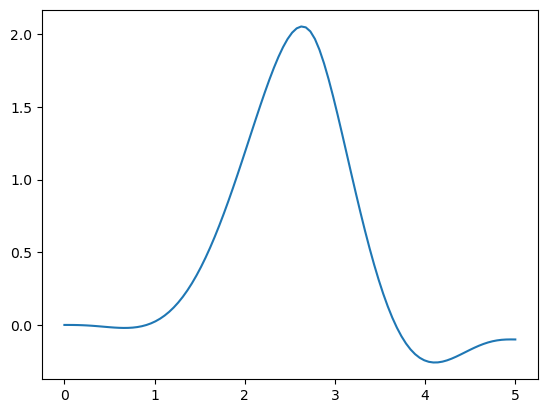

In [40]:
def polyfit(x_arr, y_arr, dy_arr, d2y_arr):
    
    n_none = 0

    for lst in [y_arr, dy_arr, d2y_arr]:
        
        lst = lst.tolist()
        n_none += lst.count(None)
    
    dof = 3*len(x_arr) - n_none

    Phi = []
    Y   = []

    for i, x in enumerate(x_arr):

        y = y_arr[i]
        dy = dy_arr[i]
        d2y = d2y_arr[i]

        if y is not None:
            Phi.append(np.array([x**i for i in range(dof)]).T)
            Y.append(y)

        if dy is not None:
            Phi.append(np.array([i*x**np.clip(i-1, a_min=0, a_max=None) for i in range(dof)]).T)
            Y.append(dy)

        if d2y is not None:
            Phi.append(np.array([i*(i-1)*x**np.clip(i-2, a_min=0, a_max=None) for i in range(dof)]).T)
            Y.append(d2y)
        
    Phi = np.array(Phi)

    Y  = np.array(Y)

    return np.linalg.solve(Phi, Y)

def polyval(x, coef, func = True, grad = False, hess = False):

    dof = len(coef)

    if func:
        Phi = np.array([x**i for i in range(dof)]).T
    
    elif grad:
        Phi = np.array([i*x**np.clip(i-1, a_min=0, a_max=None) for i in range(dof)]).T

    elif hess:
        Phi = np.array([i*(i-1)*x**np.clip(i-2, a_min=0, a_max=None) for i in range(dof)]).T

    if x.ndim == 1:
        return np.dot(Phi, coef)

    else:
        return np.dot(Phi, coef.reshape(-1,1)).flatten()

def splinefit(x_arr, y_arr, dy_arr, d2y_arr):

    coef_lst = []

    for i in range(len(x_arr) - 1):
        coef_lst.append(polyfit(x_arr[i:i+2], y_arr[i:i+2], dy_arr[i:i+2], d2y_arr[i:i+2]))
    
    return coef_lst

def splineval(x_arr, coef_lst, knots_pts, func = True, grad = False, hess = False):
    
    y = np.zeros(x_arr.shape)

    for i ,x in enumerate(x_arr): 
        idx = np.searchsorted(knots_pts, x) - 1
        if 0 <= idx <= len(coef_lst) - 1:
            y[i] = polyval(x, coef_lst[idx], func, grad, hess).flatten()
        else:
            y[i] = 0

    return y

x_knot = np.array([0 , 2.75, 5])
y_knot = np.array([0, 2, -0.1])
dy_knot = np.array([0, -1, -0.01])
d2y_knot = np.array([0, -10, -0.05])

coef_lst = splinefit(x_knot, y_knot, dy_knot, d2y_knot)
coef = polyfit(x_knot, y_knot, dy_knot, d2y_knot)

x_plt = np.linspace(0, 5, 100)
y_plt = splineval(x_plt, coef_lst, x_knot)
y_plt2 = polyval(x_plt, coef)
plt.plot(x_plt, y_plt)
# plt.plot(x_plt, y_plt2)

(array([13.,  8., 10., 12., 13.,  8.,  6.,  9.,  8., 13.]),
 array([-4.99523542e+01, -3.99577579e+01, -2.99631616e+01, -1.99685653e+01,
        -9.97396901e+00,  2.06272750e-02,  1.00152236e+01,  2.00098199e+01,
         3.00044161e+01,  3.99990124e+01,  4.99936087e+01]),
 <BarContainer object of 10 artists>)

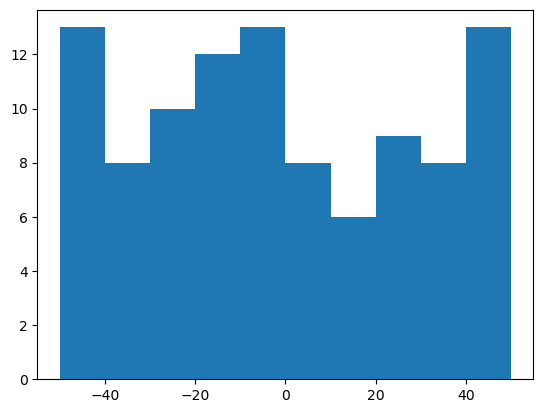

In [43]:
x = 100*(np.random.rand(100) - 0.5)

plt.hist(x)